In [1]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the datasets
customers_data = pd.read_excel(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/CustomersData.xlsx")
discount_coupon = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Discount_Coupon.csv")
marketing_spend = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Marketing_Spend.csv")
online_sales = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Online_Sales.csv")
tax_amount = pd.read_excel(r"/Users/adityamxr/Desktop/finding-marketing-insights/data/Tax_amount.xlsx")

In [4]:
# verify import

dfs =[customers_data, discount_coupon, marketing_spend, online_sales, tax_amount]

for df in dfs:
    print(df.head(), '\n\n\n')
    print(df.info())

   CustomerID Gender    Location  Tenure_Months
0       17850      M     Chicago             12
1       13047      M  California             43
2       12583      M     Chicago             33
3       13748      F  California             30
4       15100      M  California             49 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB
None
  Month Product_Category  Coupon_Code  Discount_pct
0   Jan           Apparel      SALE10            10
1   Feb           Apparel      SALE20            20
2   Mar           Apparel      SALE30            30
3   Jan          Nest-USA      ELEC10            10
4   Feb          Nest-USA   

### No nulls are present and all datatypes look appropriate, with the exception of the date features.

In [5]:
# ensure all columns in all datasets are stripped of whitespaces before converting to datetime64ns
customers_data.columns = customers_data.columns.str.strip()
discount_coupon.columns = discount_coupon.columns.str.strip()
marketing_spend.columns = marketing_spend.columns.str.strip()
online_sales.columns = online_sales.columns.str.strip()
tax_amount.columns = tax_amount.columns.str.strip()

In [6]:
# convert all date columns to datetime

# convert Transaction_Date in online_sales to datetime
online_sales['Transaction_Date'] = pd.to_datetime(online_sales['Transaction_Date'], format='%Y%m%d')

# convert Date in marketing_spend to datetime
marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])

# convert Month in discount_coupon (from Jan, Feb, etc.) to datetime (using month names)
discount_coupon['Month'] = pd.to_datetime(discount_coupon['Month'], format='%b').dt.month

## Exploratory Data Analysis

### Invoice Amount

In [7]:
# first extract Month from online_sales
if 'Month' not in online_sales.columns:
    online_sales['Month'] = online_sales['Transaction_Date'].dt.month

# merge the relevant datasets first: online sales is the main table, so left join on that is appropriate
sales_coupon_merged = pd.merge(online_sales, discount_coupon, how ='left', on= ['Product_Category', 'Month'])
sales_full_merged = pd.merge(sales_coupon_merged, tax_amount, how='left', on= ['Product_Category'])

In [8]:
# replace missing discount_pct values with 0
sales_full_merged['Discount_pct'] = sales_full_merged['Discount_pct'].fillna(0)

In [9]:
# verify merge
sales_full_merged.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,1,OFF10,10.0,0.10
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,1,SALE10,10.0,0.18
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,1,AIO10,10.0,0.18


In [10]:
# calculate invoice value
sales_full_merged['Invoice_Value'] = (
                ((sales_full_merged['Quantity'] * sales_full_merged['Avg_Price']) *
                (1 - sales_full_merged['Discount_pct']/100) *
                (1 + sales_full_merged['GST']/100)) + sales_full_merged['Delivery_Charges']
                    )


In [11]:
# verify invoice calculation
sales_full_merged['Invoice_Value'].tail(100)

52824     40.291614
52825    112.922316
52826     77.172318
52827     62.920364
52828    255.642509
            ...    
52919     91.494910
52920     40.805639
52921    112.922316
52922    288.601820
52923    245.671456
Name: Invoice_Value, Length: 100, dtype: float64

In [12]:
sales_full_merged.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10,144.977339
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,ELEC10,10.0,0.10,144.977339
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,1,OFF10,10.0,0.10,8.346845
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,1,SALE10,10.0,0.18,85.526993
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,1,AIO10,10.0,0.18,21.376730


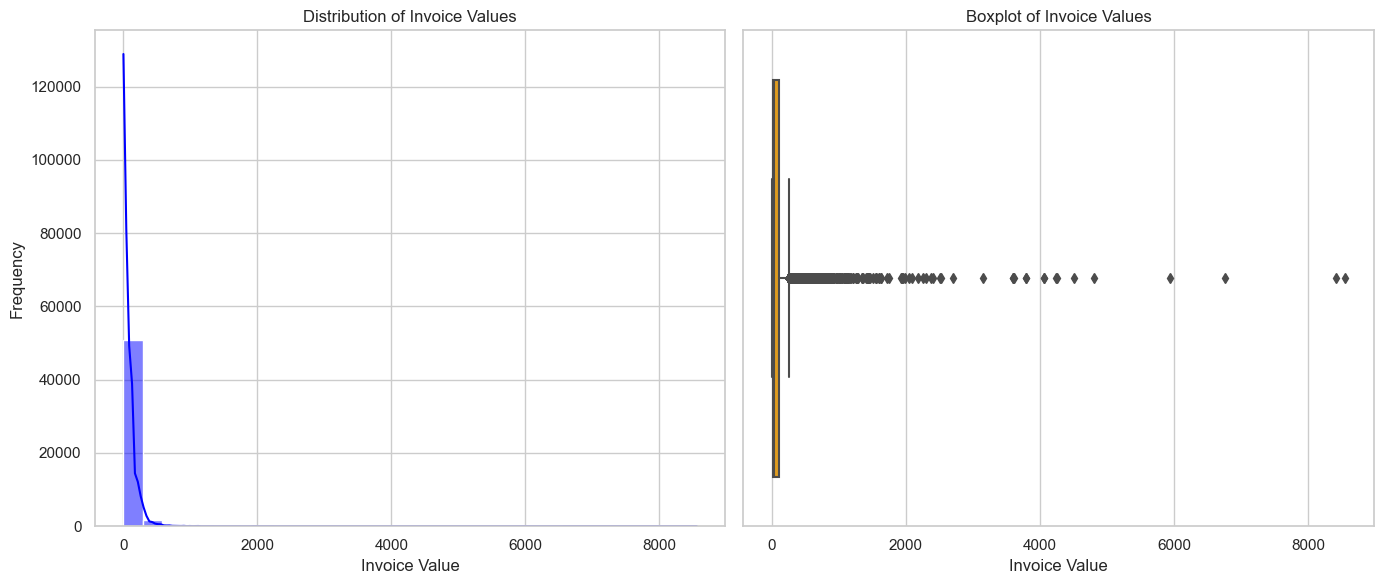

In [13]:
# set the style of seaborn
sns.set(style="whitegrid")

# create a figure to hold both plots
plt.figure(figsize=(14, 6))

# histogram to visualize the distribution of Invoice Values
plt.subplot(1, 2, 1)
sns.histplot(sales_full_merged['Invoice_Value'], bins=30, kde=True, color='blue')
plt.title('Distribution of Invoice Values')
plt.xlabel('Invoice Value')
plt.ylabel('Frequency')

# boxplot to identify outliers in Invoice Values
plt.subplot(1, 2, 2)
sns.boxplot(x=sales_full_merged['Invoice_Value'], color='orange')
plt.title('Boxplot of Invoice Values')
plt.xlabel('Invoice Value')

# show both plots
plt.tight_layout()
plt.show()

### How many customers were acquired every month?

In [14]:
# create the YearMonth column by extracting it
sales_full_merged['YearMonth'] = sales_full_merged['Transaction_Date'].dt.to_period('M')
sales_full_merged['First_Purchase_Month'] = sales_full_merged.groupby('CustomerID')['Transaction_Date'].transform('min').dt.to_period('M')

# customer_acquisition by Month
customer_acquisition = sales_full_merged.groupby('YearMonth')['CustomerID'].nunique().reset_index().rename(columns={'CustomerID': 'New_Acquired_Customers'})

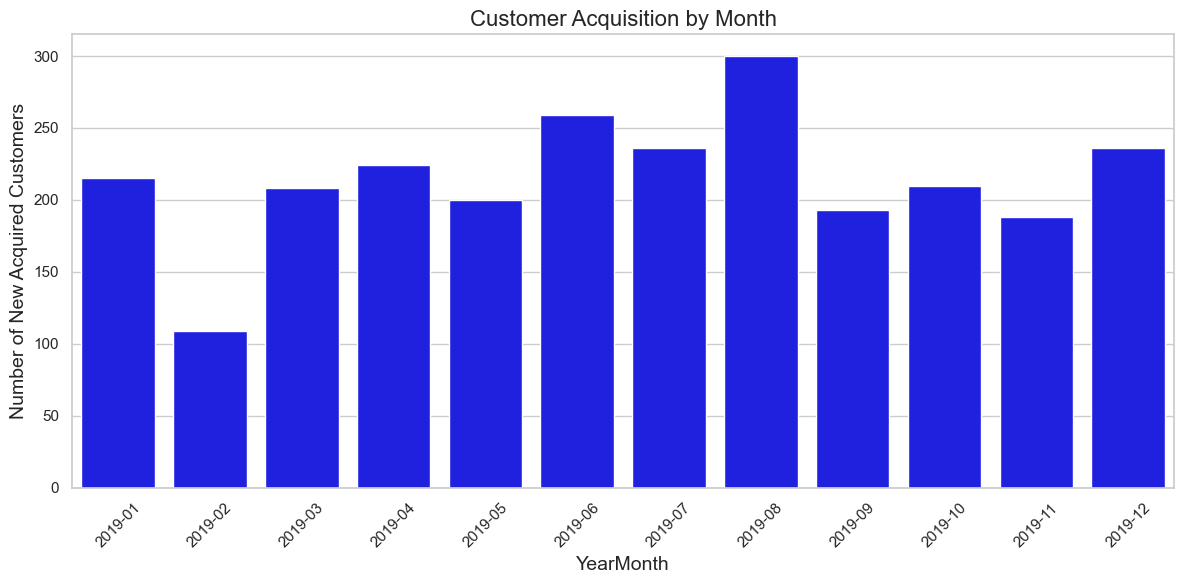

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='YearMonth', y='New_Acquired_Customers', data=customer_acquisition, color='blue')
plt.title('Customer Acquisition by Month', fontsize=16)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Number of New Acquired Customers', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### What was the customer retention on a month to month basis?

In [17]:
customer_retention = sales_full_merged[sales_full_merged['YearMonth'] != sales_full_merged['First_Purchase_Month']].groupby('YearMonth')['CustomerID'].nunique().reset_index().rename(columns={'CustomerID': 'Repeat_Customers'})

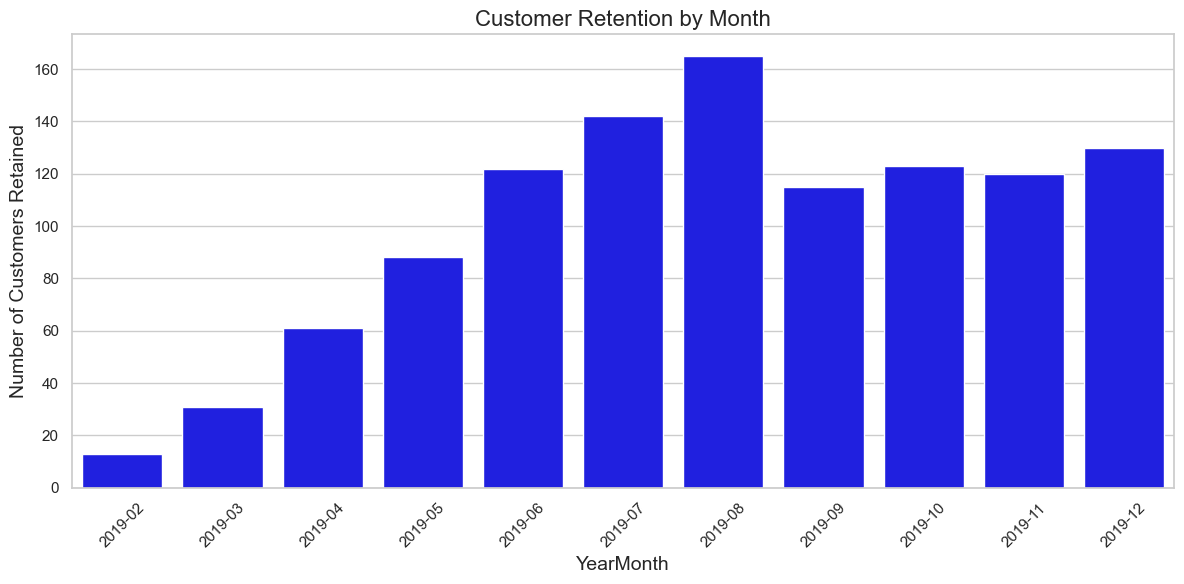

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='YearMonth', y='Repeat_Customers', data=customer_retention, color='blue')
plt.title('Customer Retention by Month', fontsize=16)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Number of Customers Retained', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### How do new customers compare with old ones? In terms of their revenue spend?

In [19]:
# new customer revenue and existing customer revenue
new_customer_revenue = sales_full_merged[sales_full_merged['YearMonth'] == sales_full_merged['First_Purchase_Month']].groupby('YearMonth')['Invoice_Value'].sum().reset_index().rename(columns={'Invoice_Value': 'New_Customer_Revenue'})
existing_customer_revenue = sales_full_merged[sales_full_merged['YearMonth'] != sales_full_merged['First_Purchase_Month']].groupby('YearMonth')['Invoice_Value'].sum().reset_index().rename(columns={'Invoice_Value': 'Existing_Customer_Revenue'})

# merge dataframes into one
customer_analysis = customer_acquisition.merge(customer_retention, on='YearMonth', how='left').merge(new_customer_revenue, on='YearMonth', how='left').merge(existing_customer_revenue, on='YearMonth', how='left').fillna(0)

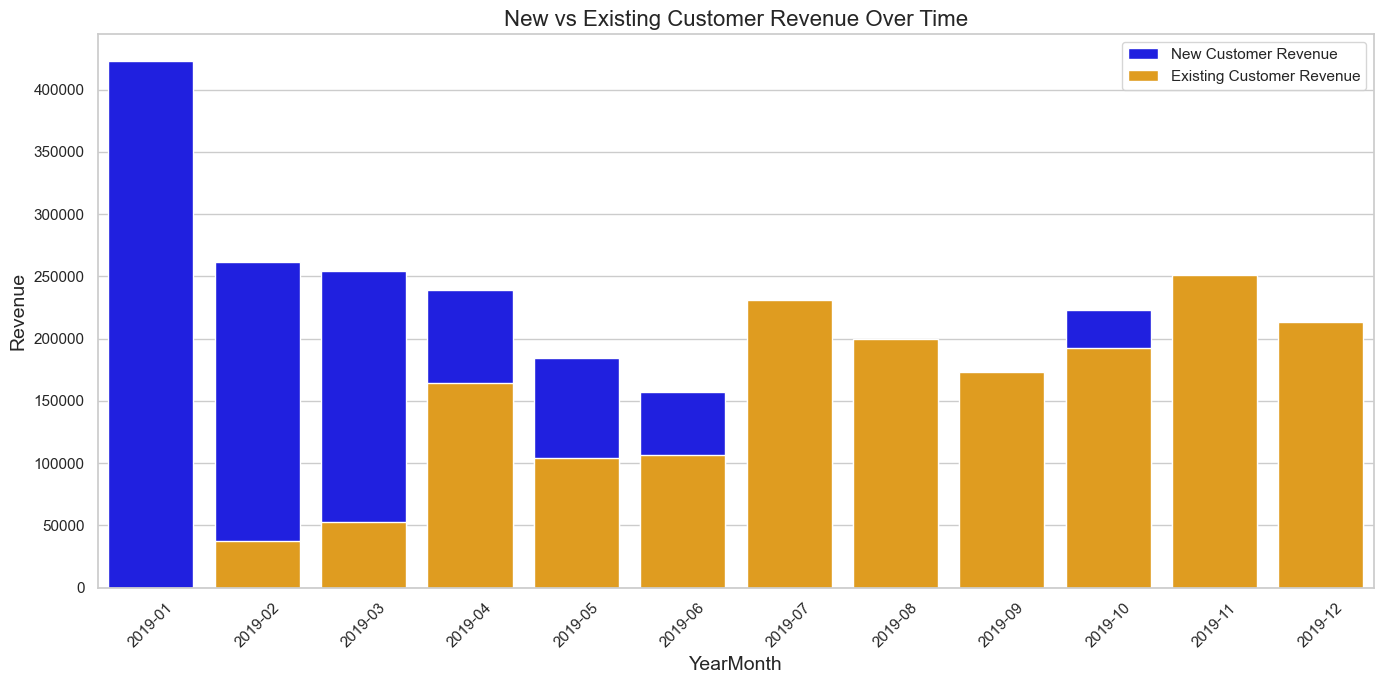

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# plot the New Customer Revenue
sns.barplot(x='YearMonth', y='New_Customer_Revenue', data=customer_analysis, color='blue', label='New Customer Revenue')

# plot the Existing Customer Revenue
sns.barplot(x='YearMonth', y='Existing_Customer_Revenue', data=customer_analysis, color='orange', label='Existing Customer Revenue')

plt.title('New vs Existing Customer Revenue Over Time', fontsize=16)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Revenue', fontsize=14)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### How are discounts affecting revenue?

In [22]:
discount_impact = sales_full_merged.groupby(['YearMonth', 'Product_Category']).agg({
    'Discount_pct': 'mean',
    'Invoice_Value':'sum',
    'Quantity': 'sum'
    }).reset_index()

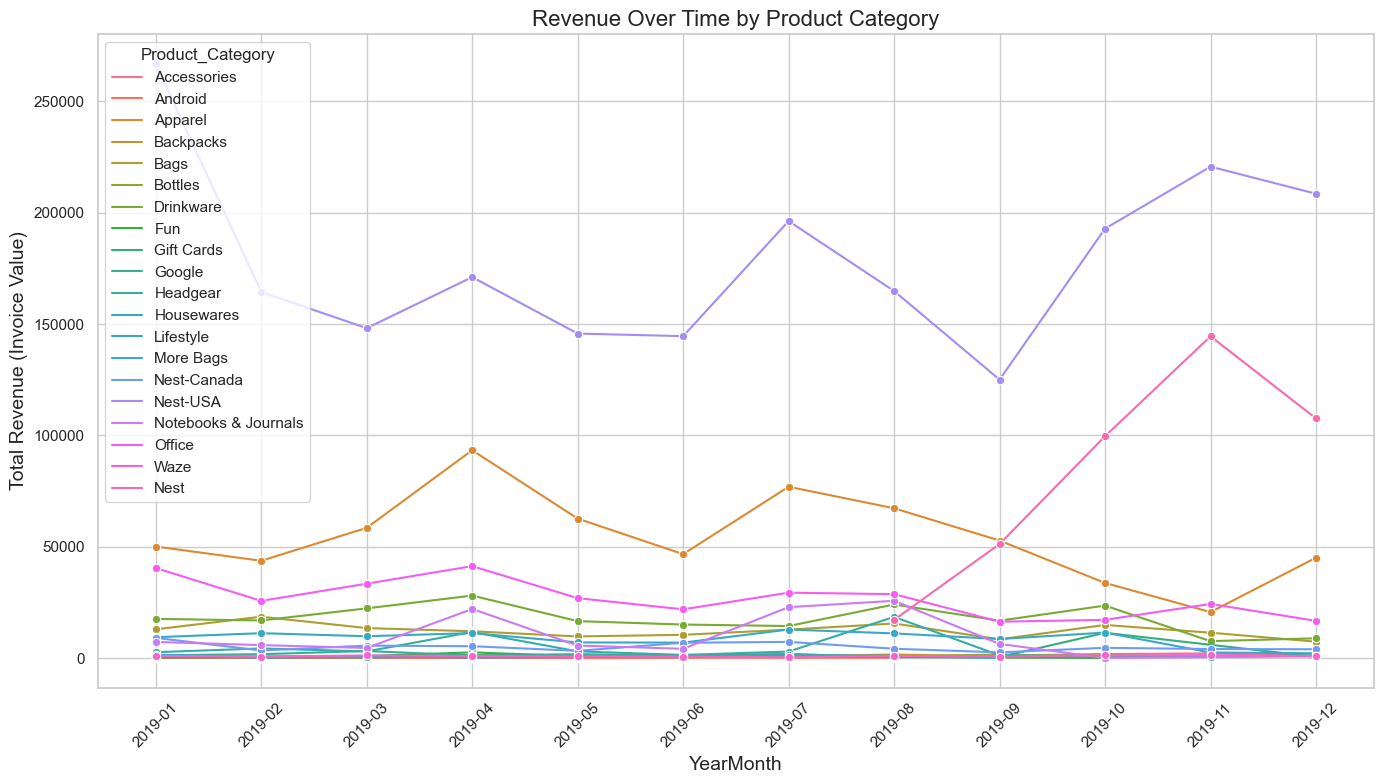

In [32]:
# Convert Invoice_Value to numeric, forcing errors to NaN
discount_impact['Invoice_Value'] = pd.to_numeric(discount_impact['Invoice_Value'], errors='coerce')

# Convert YearMonth to string format (if it's a period or date)
discount_impact['YearMonth'] = discount_impact['YearMonth'].astype(str)

# Drop rows with NaN values in Invoice_Value
discount_impact = discount_impact.dropna(subset=['Invoice_Value'])

sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))
sns.lineplot(x='YearMonth', y='Invoice_Value', hue='Product_Category', data=discount_impact, marker='o')
plt.title('Revenue Over Time by Product Category', fontsize=16)
plt.xlabel('YearMonth', fontsize=14)
plt.ylabel('Total Revenue (Invoice Value)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Key Performance Indicators (KPIs)

### KPIs by Month, Week, and Day

In [33]:
# by Month
kpi_analysis_month = sales_full_merged.groupby(['YearMonth', 'Product_Category']).agg({
    'Invoice_Value': 'sum',
    'Transaction_ID': 'nunique',
    'CustomerID': 'nunique',
    'Quantity': 'sum'
}).reset_index()

kpi_analysis_month['Avg_Order_Value'] = kpi_analysis_month['Invoice_Value'] / kpi_analysis_month['Transaction_ID']


# by Week
sales_full_merged['YearWeek'] = sales_full_merged['Transaction_Date'].dt.to_period('W')
kpi_analysis_week = sales_full_merged.groupby(['YearWeek', 'Product_Category']).agg({
    'Invoice_Value': 'sum',
    'Transaction_ID': 'nunique',
    'CustomerID': 'nunique',
    'Quantity': 'sum'
}).reset_index()

kpi_analysis_week['Avg_Order_Value'] = kpi_analysis_week['Invoice_Value'] / kpi_analysis_week['Transaction_ID']


# by Day
sales_full_merged['DayOfWeek'] = sales_full_merged['Transaction_Date'].dt.day_name()
kpi_analysis_day = sales_full_merged.groupby(['DayOfWeek', 'Product_Category']).agg({
    'Invoice_Value': 'sum',
    'Transaction_ID': 'nunique',
    'CustomerID': 'nunique',
    'Quantity': 'sum'
}).reset_index()

kpi_analysis_day['Avg_Order_Value'] = kpi_analysis_day['Invoice_Value'] / kpi_analysis_day['Transaction_ID']

In [34]:
# verify creation
kpi_analysis_day.head()

,DayOfWeek,Product_Category,Invoice_Value,Transaction_ID,CustomerID,Quantity,Avg_Order_Value
0,Friday,Accessories,2126.979740,22,20,124,96.680897
1,Friday,Android,215.930880,11,11,11,19.630080
2,Friday,Apparel,131541.469858,1436,392,7283,91.602695
3,Friday,Backpacks,529.298340,5,5,6,105.859668
4,Friday,Bags,31661.415271,293,186,3689,108.059438


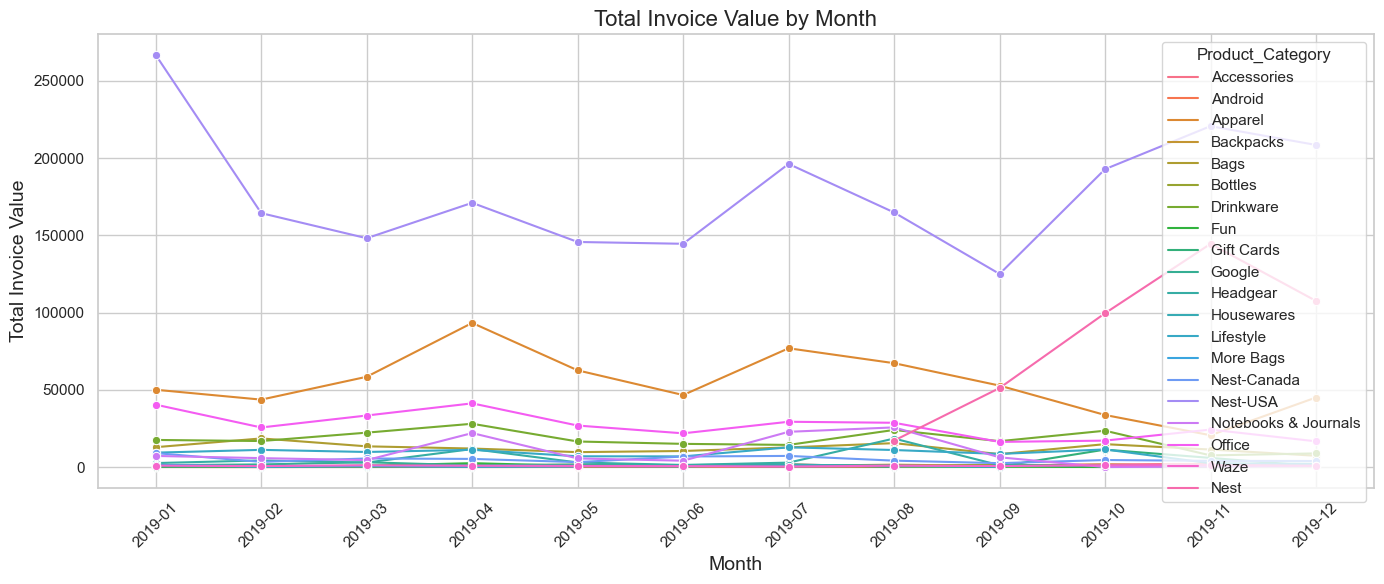

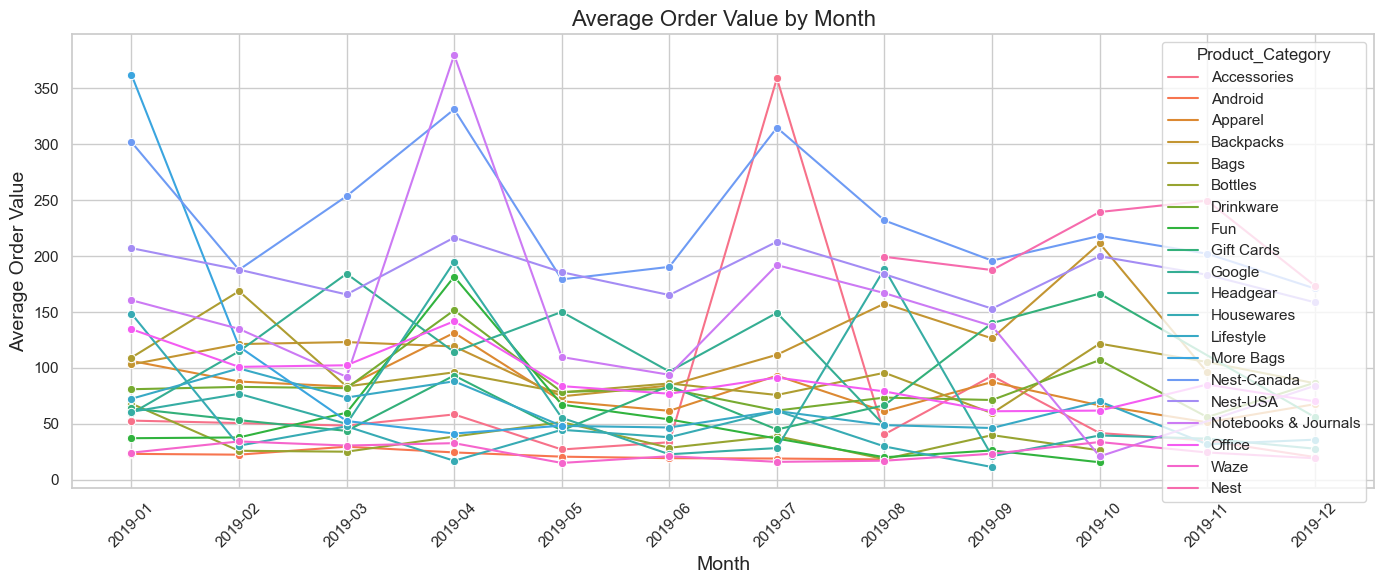

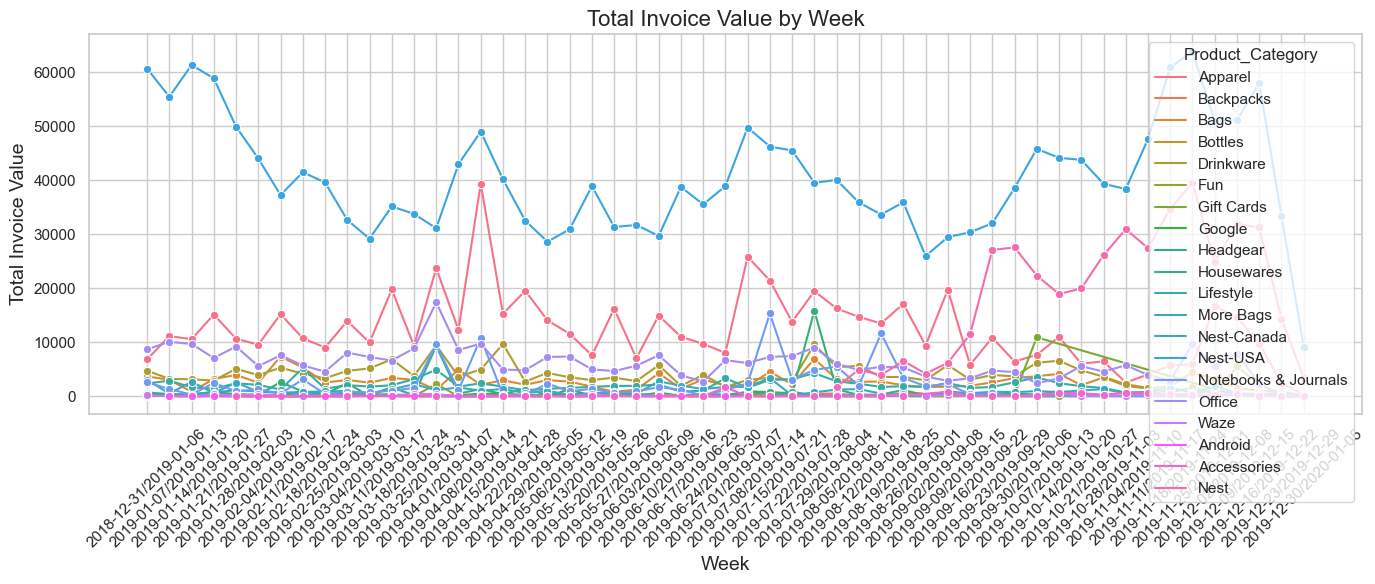

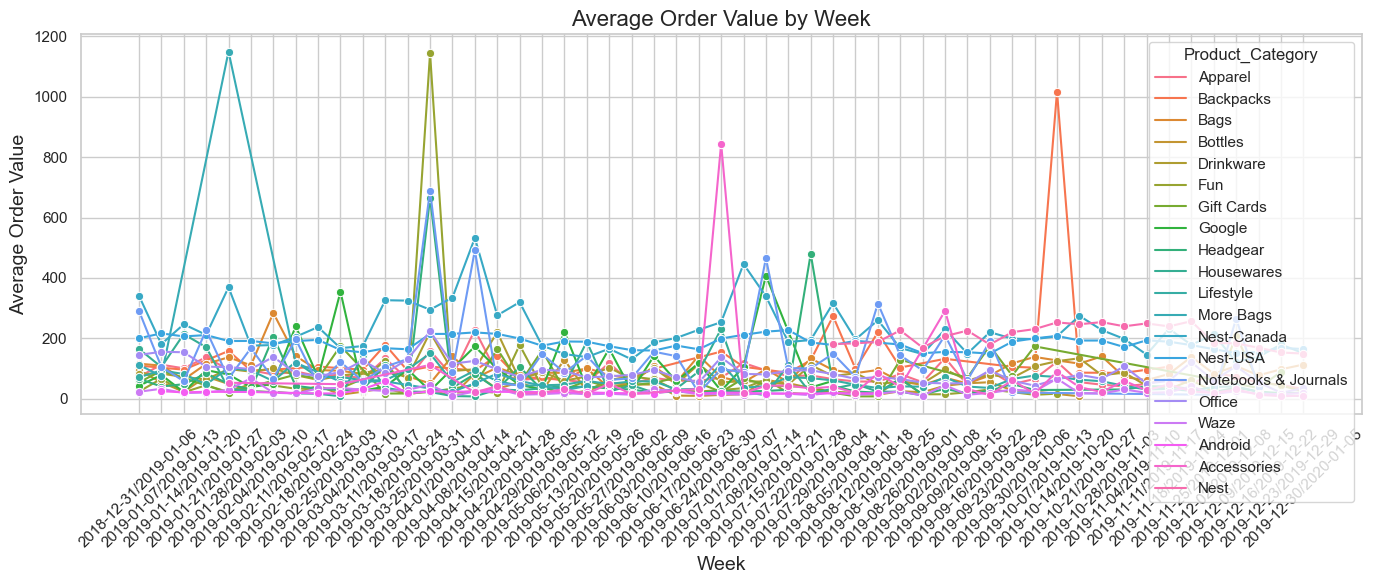

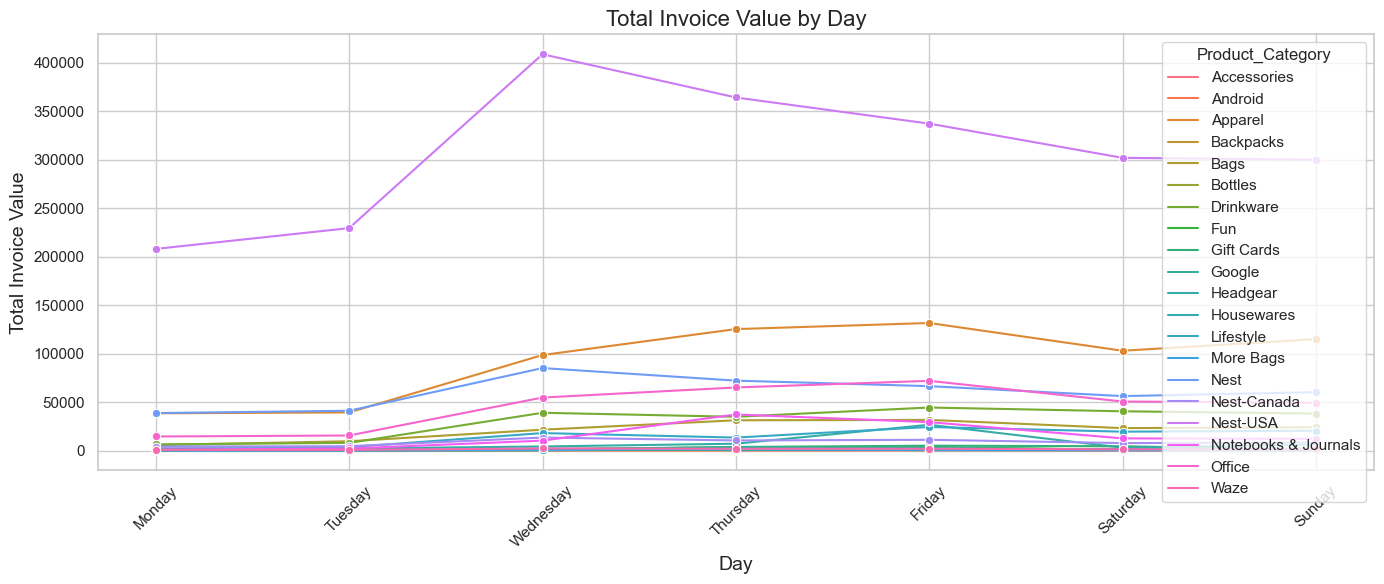

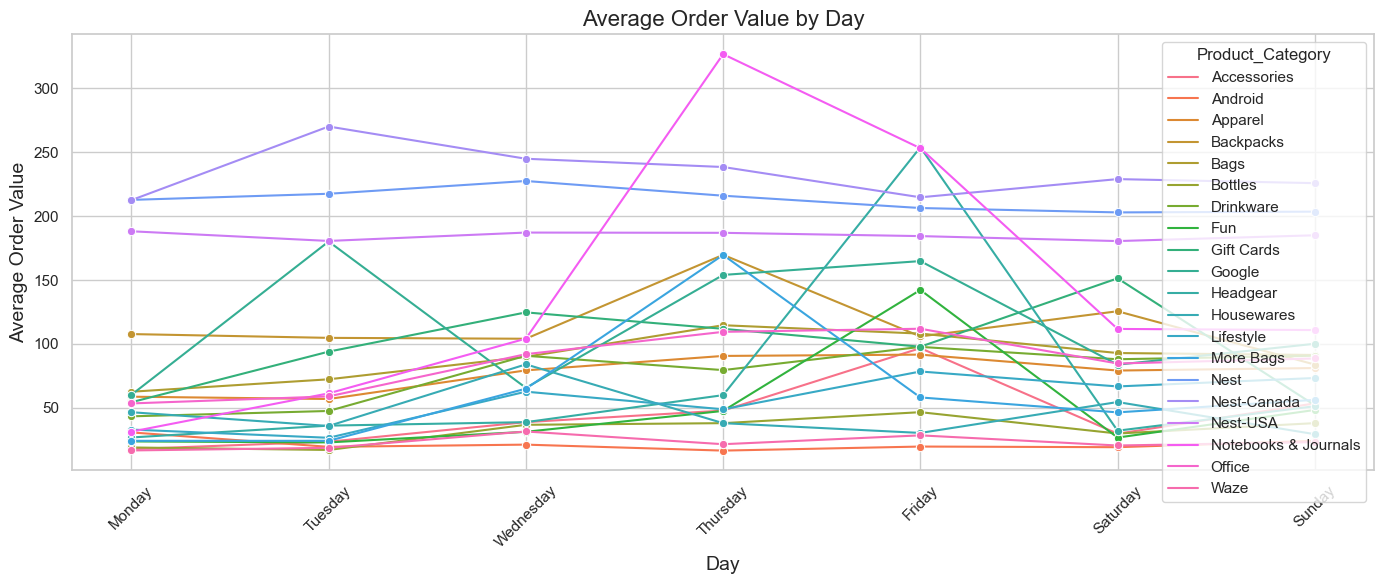

In [37]:
# ensure that the YearMonth and YearWeek are strings, and DayOfWeek is ordered correctly
kpi_analysis_month['YearMonth'] = kpi_analysis_month['YearMonth'].astype(str)
kpi_analysis_week['YearWeek'] = kpi_analysis_week['YearWeek'].astype(str)

# define the correct order for the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
kpi_analysis_day['DayOfWeek'] = pd.Categorical(kpi_analysis_day['DayOfWeek'], categories=day_order, ordered=True)

# dictionary to hold the KPI analysis data
kpi_analysis_dict = {
    'Month': ('YearMonth', kpi_analysis_month),
    'Week': ('YearWeek', kpi_analysis_week),
    'Day': ('DayOfWeek', kpi_analysis_day)
}

sns.set(style="whitegrid")

# loop through the dictionary and create plots for each time period
for period, (x_column, data) in kpi_analysis_dict.items():
    
    # figure for Invoice Value
    plt.figure(figsize=(14, 6))
    sns.lineplot(x=x_column, y='Invoice_Value', hue='Product_Category', data=data, marker='o')
    plt.title(f'Total Invoice Value by {period}', fontsize=16)
    plt.xlabel(f'{period}', fontsize=14)
    plt.ylabel('Total Invoice Value', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # figure for Average Order Value
    plt.figure(figsize=(14, 6))
    sns.lineplot(x=x_column, y='Avg_Order_Value', hue='Product_Category', data=data, marker='o')
    plt.title(f'Average Order Value by {period}', fontsize=16)
    plt.xlabel(f'{period}', fontsize=14)
    plt.ylabel('Average Order Value', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Trends / Seasonality by Product Category, Location, and Month

In [38]:
# adding customer location
sales_with_location = pd.merge(sales_full_merged, customers_data[['CustomerID', 'Location']], on='CustomerID', how='left')

# trends by category, location, and month
trend_analysis = sales_with_location.groupby(['YearMonth', 'Product_Category', 'Location']).agg({
    'Invoice_Value': 'sum',
    'Quantity': 'sum',
    'Transaction_ID': 'nunique'
}).reset_index()

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/8w/cpbqlrpx2_vdb3s9mc69y3cw0000gn/T/ipykernel_90187/2024955840.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/8w/cpbqlrpx2_vdb3s9mc69y3cw0000gn/T/ipykernel_90187/2024955840.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


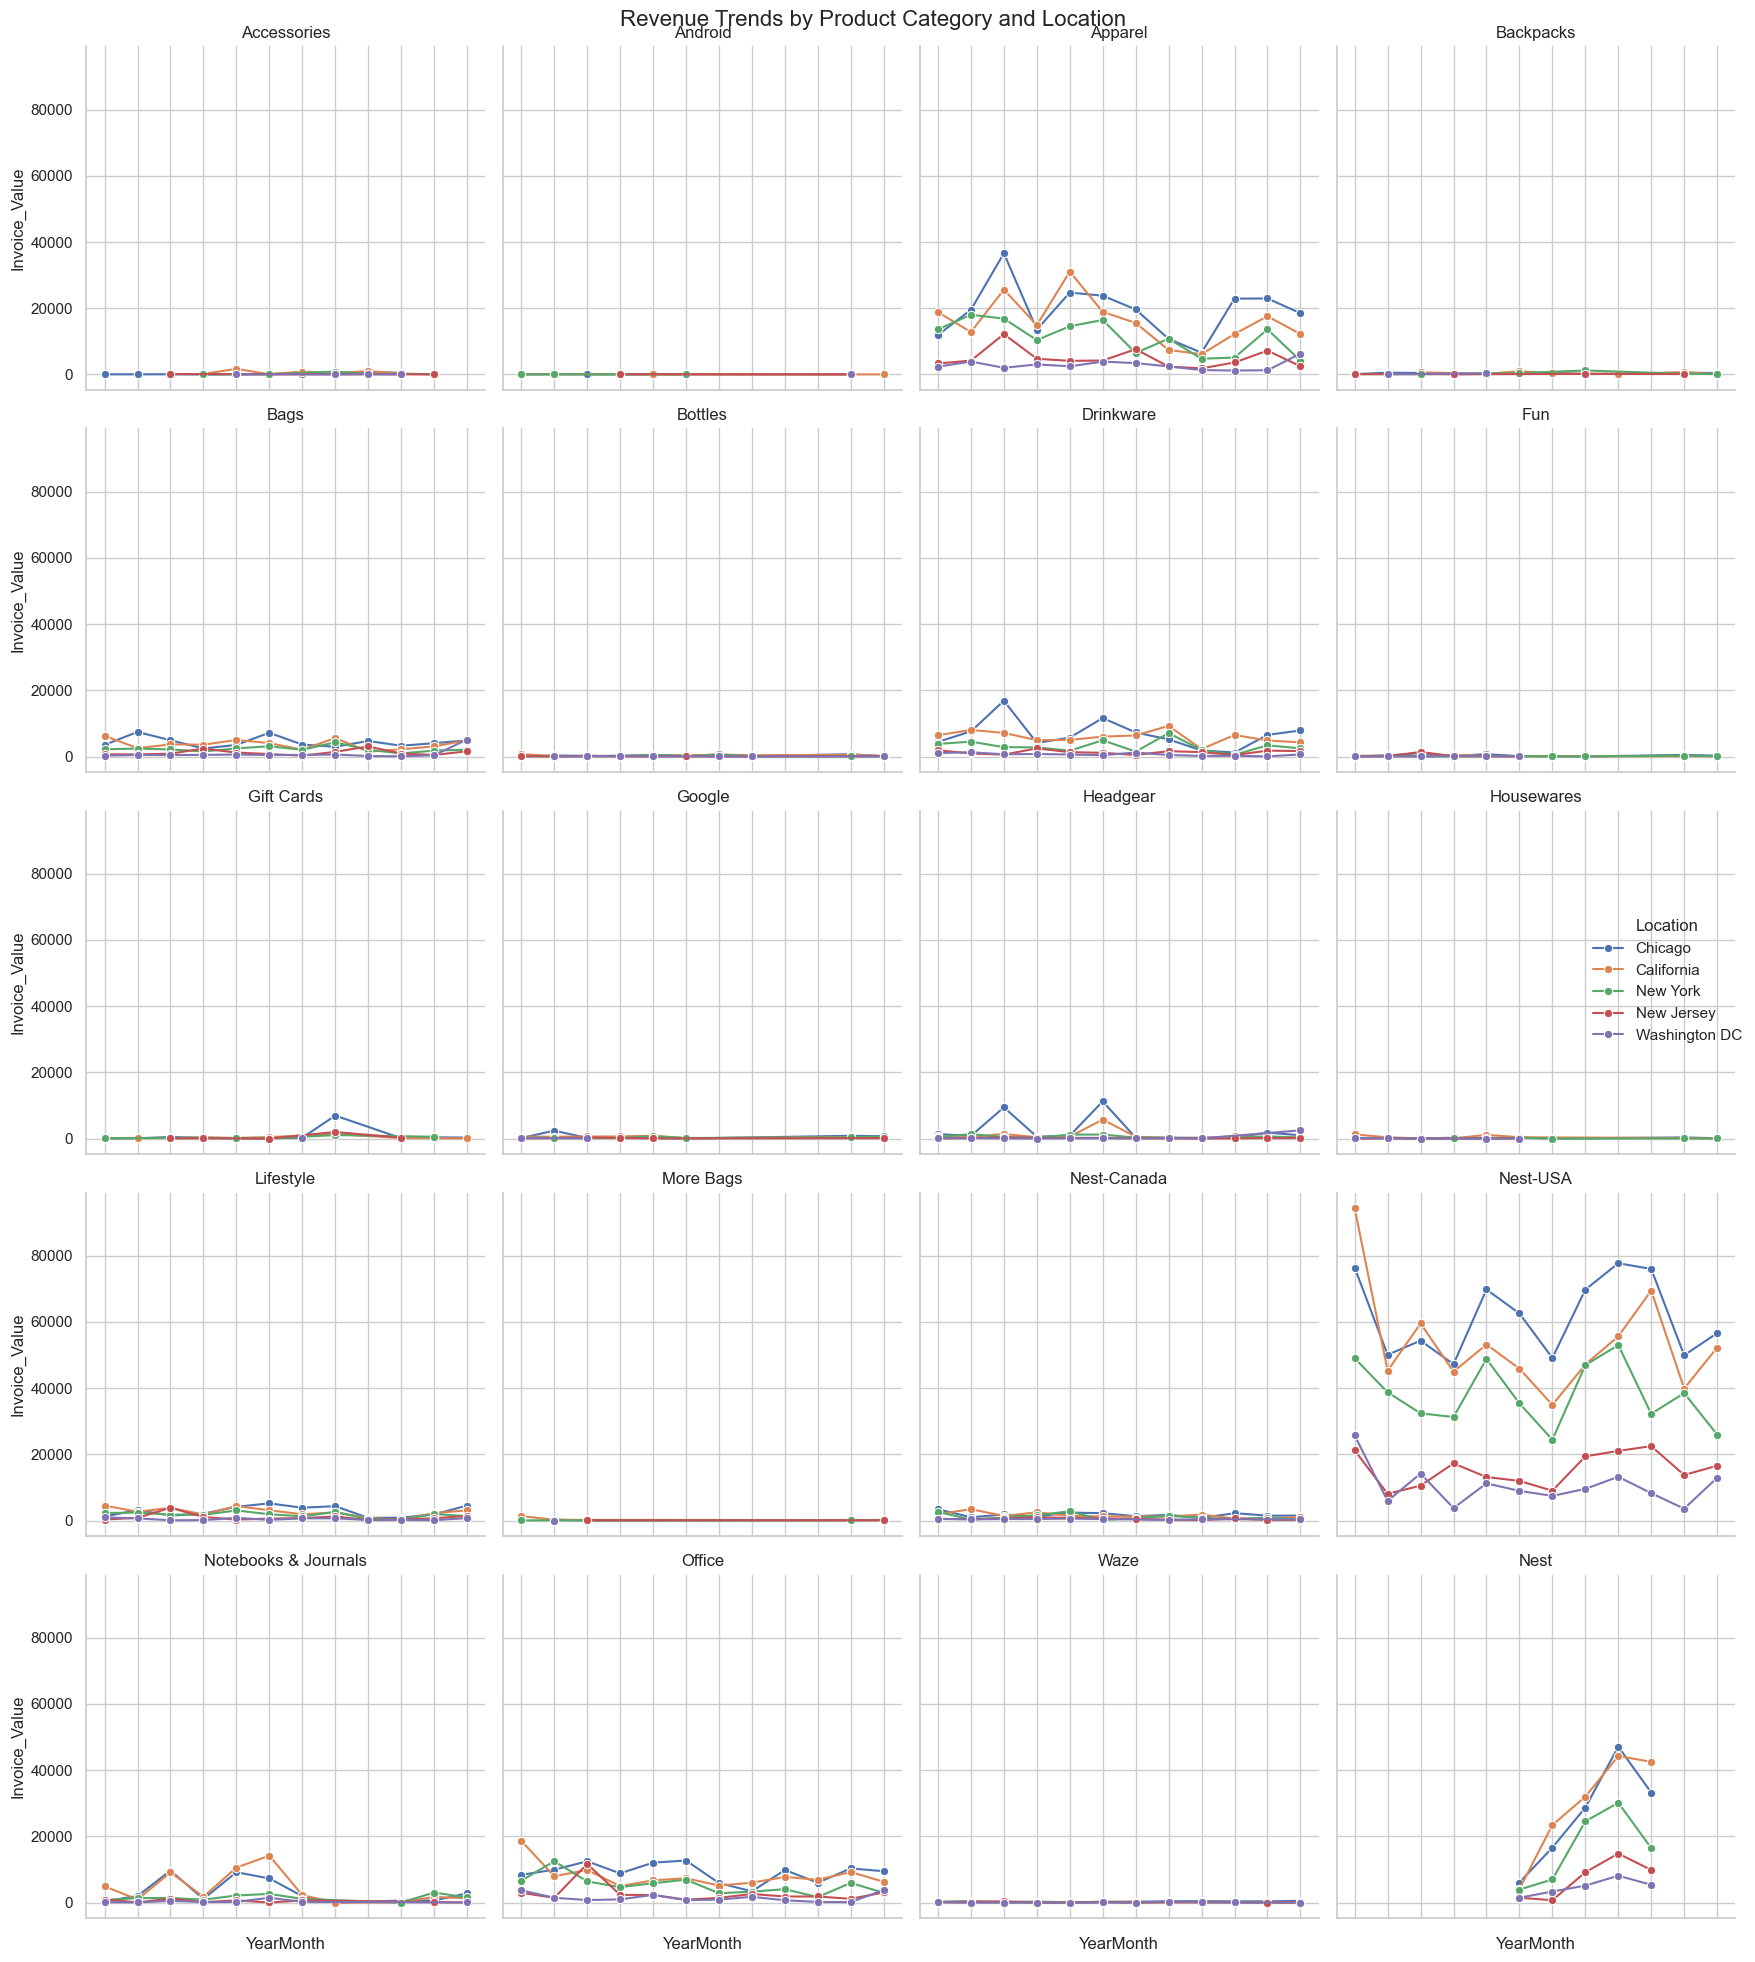

In [40]:
sns.set(style="whitegrid")

# ensure that YearMonth is a string for plotting
trend_analysis['YearMonth'] = trend_analysis['YearMonth'].astype(str)

# FacetGrid to plot Invoice Value trends by Product Category and Location
g = sns.FacetGrid(trend_analysis, col='Product_Category', hue='Location', col_wrap=4, height=4)
g.map(sns.lineplot, 'YearMonth', 'Invoice_Value', marker='o').add_legend()
g.set_titles('{col_name}')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Revenue Trends by Product Category and Location', fontsize=16)
plt.tight_layout()
plt.show()

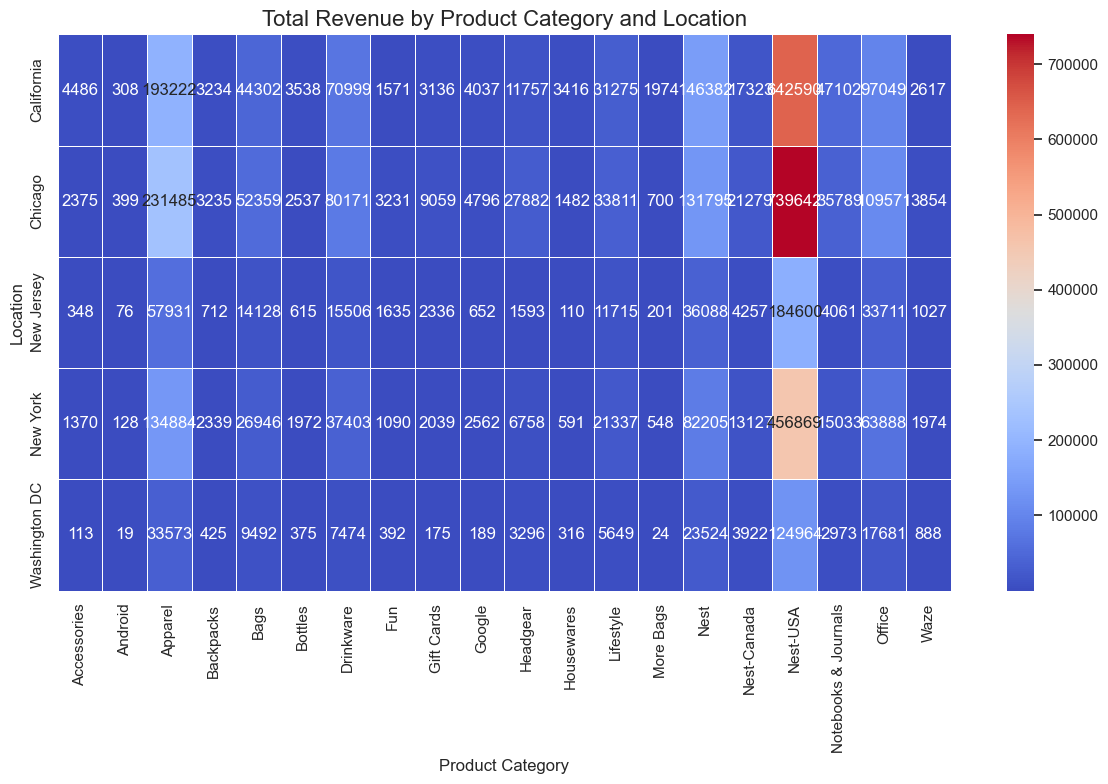

In [42]:
# pivot table for heatmap: Revenue by Product Category and Location
pivot_table = trend_analysis.pivot_table(
    values='Invoice_Value',
    index='Location',
    columns='Product_Category',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='coolwarm', linewidths=0.5)
plt.title('Total Revenue by Product Category and Location', fontsize=16)
plt.xlabel('Product Category')
plt.ylabel('Location')
plt.tight_layout()
plt.show()

## Marketing Spend's Impact on Revenue

In [46]:
# First, convert Date columns to datetime format (already done)
sales_full_merged['Transaction_Date'] = pd.to_datetime(sales_full_merged['Transaction_Date'])
marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])

# Remove the Date column from the summation and sum only numeric columns
# Group by YearMonth and aggregate spend data
monthly_spend = marketing_spend.groupby(marketing_spend['Date'].dt.to_period('M')).agg({
    'Offline_Spend': 'sum',
    'Online_Spend': 'sum'
}).reset_index().rename(columns={'Date': 'YearMonth'})

# Calculate total spend
monthly_spend['Total_Spend'] = monthly_spend['Offline_Spend'] + monthly_spend['Online_Spend']

# Merge with monthly revenue
spend_revenue = pd.merge(monthly_revenue, monthly_spend, on='YearMonth', how='left')

# Calculate marketing spend percentage
spend_revenue['Marketing_Spend_Percentage'] = (spend_revenue['Total_Spend'] / spend_revenue['Total_Revenue']) * 100

# Tax and delivery charges percentage
tax_delivery_analysis = sales_full_merged.groupby('YearMonth').agg({
    'Invoice_Value': 'sum',
    'Delivery_Charges': 'sum',
    'GST': 'sum'
}).reset_index()

# Calculate tax and delivery percentages
tax_delivery_analysis['Tax_Percentage'] = (tax_delivery_analysis['GST'] / tax_delivery_analysis['Invoice_Value']) * 100
tax_delivery_analysis['Delivery_Charges_Percentage'] = (tax_delivery_analysis['Delivery_Charges'] / tax_delivery_analysis['Invoice_Value']) * 100

# Correlation between marketing spend and revenue
marketing_revenue_corr = spend_revenue[['Total_Revenue', 'Total_Spend']].corr()
print(marketing_revenue_corr)

               Total_Revenue  Total_Spend
Total_Revenue       1.000000     0.626784
Total_Spend         0.626784     1.000000


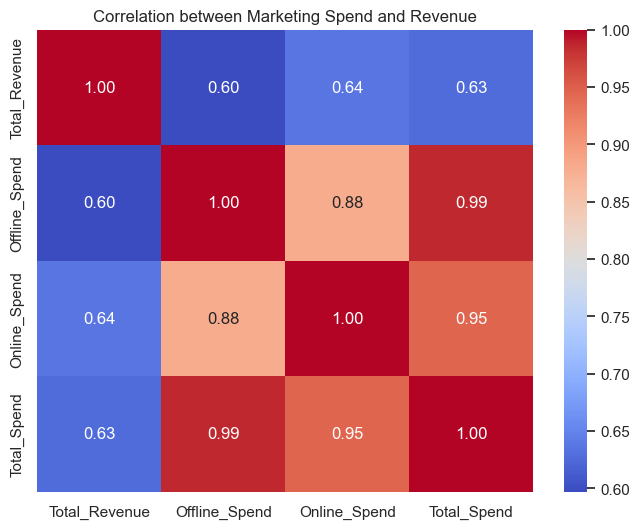

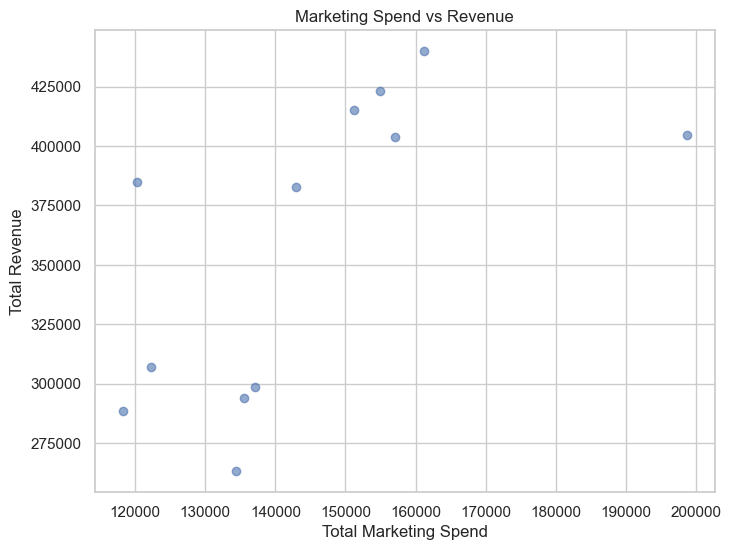

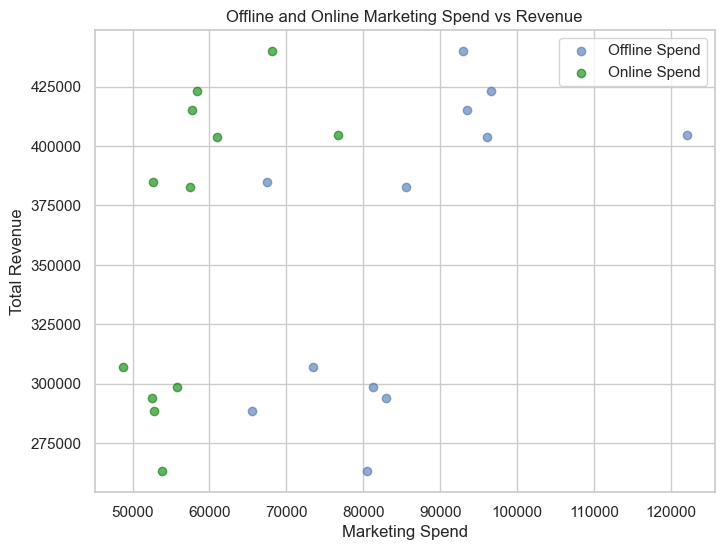

In [47]:
# Calculate correlations between revenue and marketing spend
correlation_matrix = spend_revenue[['Total_Revenue', 'Offline_Spend', 'Online_Spend', 'Total_Spend']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation between Marketing Spend and Revenue")
plt.show()

# Scatter plot for Total Spend vs Total Revenue
plt.figure(figsize=(8,6))
plt.scatter(spend_revenue['Total_Spend'], spend_revenue['Total_Revenue'], alpha=0.6)
plt.title('Marketing Spend vs Revenue')
plt.xlabel('Total Marketing Spend')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

# Scatter plots for Offline and Online Spend separately
plt.figure(figsize=(8,6))
plt.scatter(spend_revenue['Offline_Spend'], spend_revenue['Total_Revenue'], alpha=0.6, label='Offline Spend')
plt.scatter(spend_revenue['Online_Spend'], spend_revenue['Total_Revenue'], alpha=0.6, label='Online Spend', color='green')
plt.title('Offline and Online Marketing Spend vs Revenue')
plt.xlabel('Marketing Spend')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.legend()
plt.show()